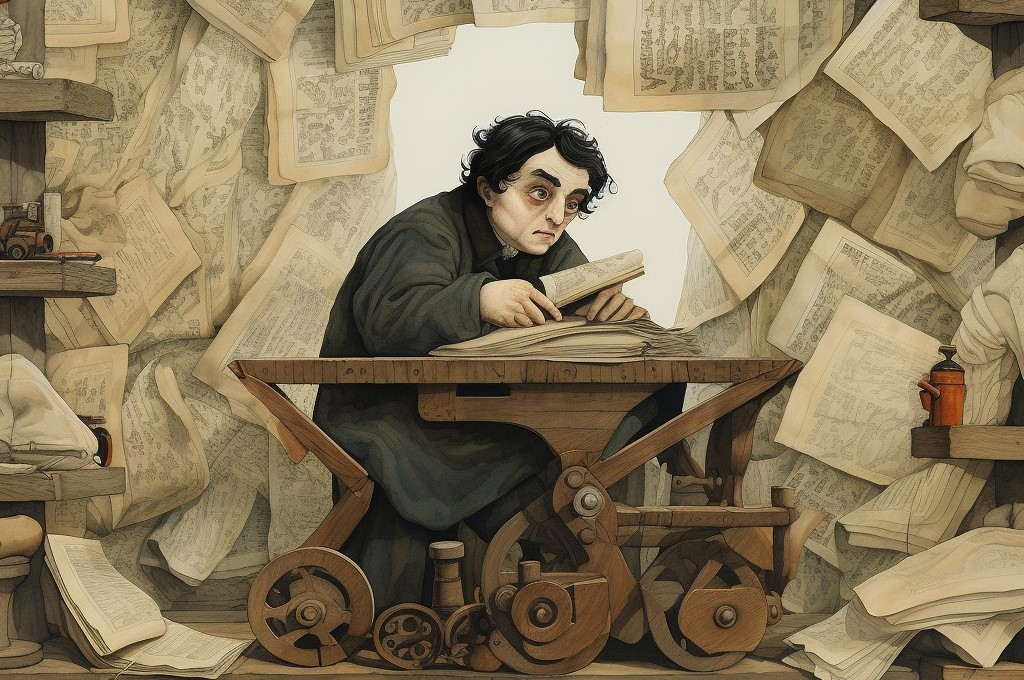
<center> Изображение сгенерировано midjourney по запросу "наивный Байес любуется текстами на свитках".

# Классификация текстов с использованием Наивного Байесовского Классификатора

## Загрузка данных

In [1]:
# Импортируем необходимые библиотеки
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import metrics # метрики
from sklearn import naive_bayes # модели НБК
from sklearn.feature_extraction.text import CountVectorizer # векторизатор
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.model_selection import cross_val_score # кросс-валидация
import optuna # оптимизация гиперпараметров

plt.style.use('seaborn-v0_8') # стиль отрисовки seaborn
%matplotlib inline

spam_data = pd.read_csv('data/spam_or_not_spam.zip')
spam_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


Узнаем размеры классов.

In [2]:
spam_data.label.value_counts()

0    2500
1     500
Name: label, dtype: int64

not spam: 83.33%
spam: 16.67%


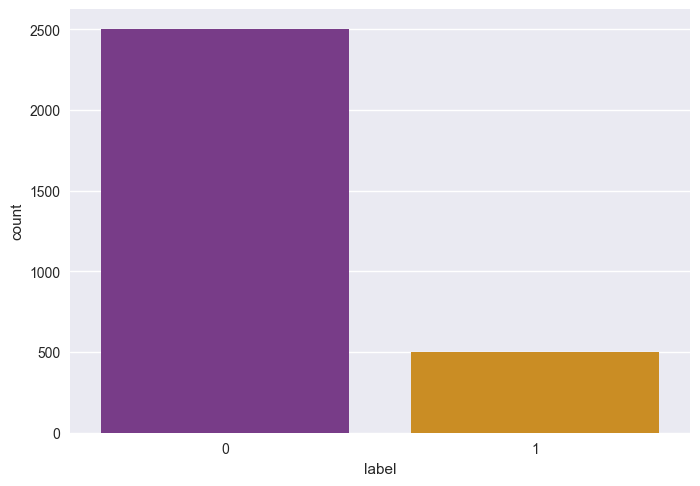

In [3]:
sns.countplot(x='label', data=spam_data, palette='CMRmap')
class_percent = spam_data['label'].value_counts(normalize=True) * 100
print('not spam: {:.2f}%'.format(class_percent[0]))
print('spam: {:.2f}%'.format(class_percent[1]))

Типы сообщений представлены довольно разными по размеру классами.

## Предобработка данных

Нам необходимо предобработать данные и перевести их в векторный вид. Также заменим в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалим из данных все строки, в которых наблюдаются пропущенные значения.

In [4]:
spam_data['email'] = spam_data['email'].replace('^\s*$', None, regex=True)
print(spam_data.isna().sum())
spam_data = spam_data.dropna()

email    3
label    0
dtype: int64


Как видим, неинформативных строк оказалось очень мало.

Переводим данные в векторный вид:

In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(spam_data["email"])

Взглянем на обновленное число признаков в нашем наборе данных:

In [6]:
X.shape[1]

34116

## Разделение данных

Определим целевую переменную:

In [7]:
y = spam_data['label']

Разделим выборку на обучающую и тестовую, используя стратифицированное разбиение, размер тестовой выборки - 0.25:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Обучение модели

Выставим параметр сглаживания alpha сперва 0.01.

In [9]:
# Инициализируем объект ComplementNB
cnb_model = naive_bayes.ComplementNB(alpha=0.01)
# Обучим модель
cnb_model.fit(X_train, y_train)
# Сделаем предсказания для обеих выборок
y_train_pred = cnb_model.predict(X_train)
y_test_pred = cnb_model.predict(X_test)

Оценим результат:

In [10]:
# Вывод отчета о метриках треннировочной выборки
print(metrics.classification_report(y_train, y_train_pred, digits=3))

# Вывод отчета о метриках тестовой выборки
print(metrics.classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     1.000     1.000      1874
           1      1.000     0.997     0.999       373

    accuracy                          1.000      2247
   macro avg      1.000     0.999     0.999      2247
weighted avg      1.000     1.000     1.000      2247

              precision    recall  f1-score   support

           0      0.986     1.000     0.993       626
           1      1.000     0.927     0.962       124

    accuracy                          0.988       750
   macro avg      0.993     0.964     0.978       750
weighted avg      0.988     0.988     0.988       750



Нарисуем ROC-кривую:

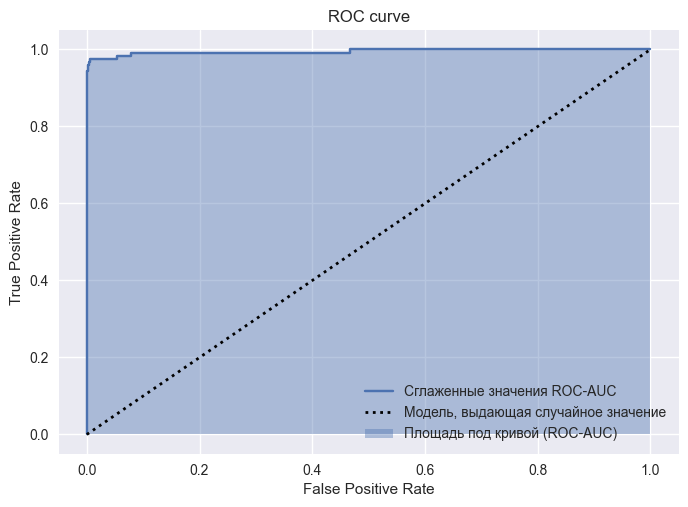

roc-auc на тестовой выборке: 0.9951


In [11]:
# Выберем значения предсказаний для объектов одного из классов
pred_proba = cnb_model.predict_proba(X_test)[:, 1]
# Доли ложно-положительных и истинных значений в предсказаниях в зависимости от порога
false_positive_rates, true_positive_rates, threshold = metrics.roc_curve(y_test, pred_proba)

# рисуем кривую
plt.plot(
    false_positive_rates,
    true_positive_rates, 
    label='Сглаженные значения ROC-AUC'
)

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(
    false_positive_rates,
    true_positive_rates, step="pre", 
    alpha=0.4, label='Площадь под кривой (ROC-AUC)'
)

plt.legend()
plt.show()

roc_auc_cnb = metrics.roc_auc_score(y_test, pred_proba).round(4)
print("roc-auc на тестовой выборке:", roc_auc_cnb)

## Оптимизация модели

Переберем значения alpha с помощью автоматического оптимизатора с кросс-валидацией.

In [12]:
%%time
# Напишем функцию для оптимизации
def optuna_cnb(trial):
    """Функция, обучающая модель ComplementNB по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространство поиска гиперпараметров
    alpha = trial.suggest_float('alpha', 0.001, 1)
    # Создаем модель
    model = naive_bayes.ComplementNB(alpha=alpha)
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_cnb = optuna.create_study(
    study_name="cnb_opt",
    direction="maximize"
)

# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_cnb.optimize(optuna_cnb, n_trials=50)
print("Наилучшие гиперпараметры {}".format(study_cnb.best_params))
print("f1_score на обучающем наборе: {:.4f}\n".format(study_cnb.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
cnb_opt = naive_bayes.ComplementNB(**study_cnb.best_params)
cnb_opt.fit(X_train, y_train)
y_pred_test_cnb_opt = cnb_opt.predict(X_test)
print(f'cnb_opt accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_test_cnb_opt), 4)}')
print(f'cnb_opt f1-score: {round(metrics.f1_score(y_test, y_pred_test_cnb_opt), 4)}')
pred_proba_cnb_opt = cnb_opt.predict_proba(X_test)[:, 1]
roc_auc_cnb_opt = metrics.roc_auc_score(y_test, pred_proba_cnb_opt).round(4)
print("roc-auc на тестовой выборке:", roc_auc_cnb_opt)

[I 2023-11-23 16:14:23,034] A new study created in memory with name: cnb_opt


Наилучшие гиперпараметры {'alpha': 0.3962645812333469}
f1_score на обучающем наборе: 0.9745

cnb_opt accuracy-score: 0.9947
cnb_opt f1-score: 0.9837
roc-auc на тестовой выборке: 0.9983
Wall time: 9.07 s


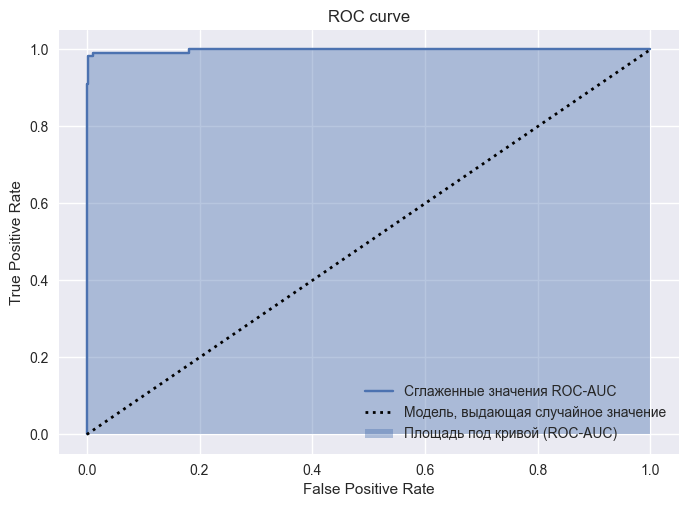

In [13]:
# Выберем значения предсказаний для объектов одного из классов
pred_proba = cnb_opt.predict_proba(X_test)[:, 1]
# Доли ложно-положительных и истинных значений в предсказаниях в зависимости от порога
false_positive_rates, true_positive_rates, threshold = metrics.roc_curve(y_test, pred_proba)

# рисуем кривую
plt.plot(
    false_positive_rates,
    true_positive_rates, 
    label='Сглаженные значения ROC-AUC'
)

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(
    false_positive_rates,
    true_positive_rates, step="pre", 
    alpha=0.4, label='Площадь под кривой (ROC-AUC)'
)

plt.legend()
plt.show()

## Итог

Качество классификации после оптимизации коэффициента alpha стала лучше:

In [14]:
# Вывод отчета о метриках тестовой выборки
print(metrics.classification_report(y_test, y_test_pred, digits=3))
# Вывод отчета о метриках тестовой выборки
print(metrics.classification_report(y_test, y_pred_test_cnb_opt, digits=3))

              precision    recall  f1-score   support

           0      0.986     1.000     0.993       626
           1      1.000     0.927     0.962       124

    accuracy                          0.988       750
   macro avg      0.993     0.964     0.978       750
weighted avg      0.988     0.988     0.988       750

              precision    recall  f1-score   support

           0      0.995     0.998     0.997       626
           1      0.992     0.976     0.984       124

    accuracy                          0.995       750
   macro avg      0.994     0.987     0.990       750
weighted avg      0.995     0.995     0.995       750

